In [1]:
# Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

In [2]:
# Loading the csv file as data frame
listings = pd.read_csv('../data/clean/listings_clean_dummy_encoding.csv')

In [3]:
# converting data type to datetime.
listings[['host_since']] = listings[['host_since']].apply(pd.to_datetime)

In [4]:
# changing data type of is,host_id columns to object
listings[['host_id']] = listings[['host_id']].astype('object')

In [5]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6882 entries, 0 to 6881
Data columns (total 48 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   host_id                                       6882 non-null   object        
 1   host_since                                    6867 non-null   datetime64[ns]
 2   host_response_time                            6882 non-null   object        
 3   host_response_rate                            6882 non-null   object        
 4   host_acceptance_rate                          6882 non-null   object        
 5   host_is_superhost                             6882 non-null   float64       
 6   host_verifications                            6882 non-null   int64         
 7   host_has_profile_pic                          6882 non-null   float64       
 8   host_identity_verified                        6882 non-null   float6

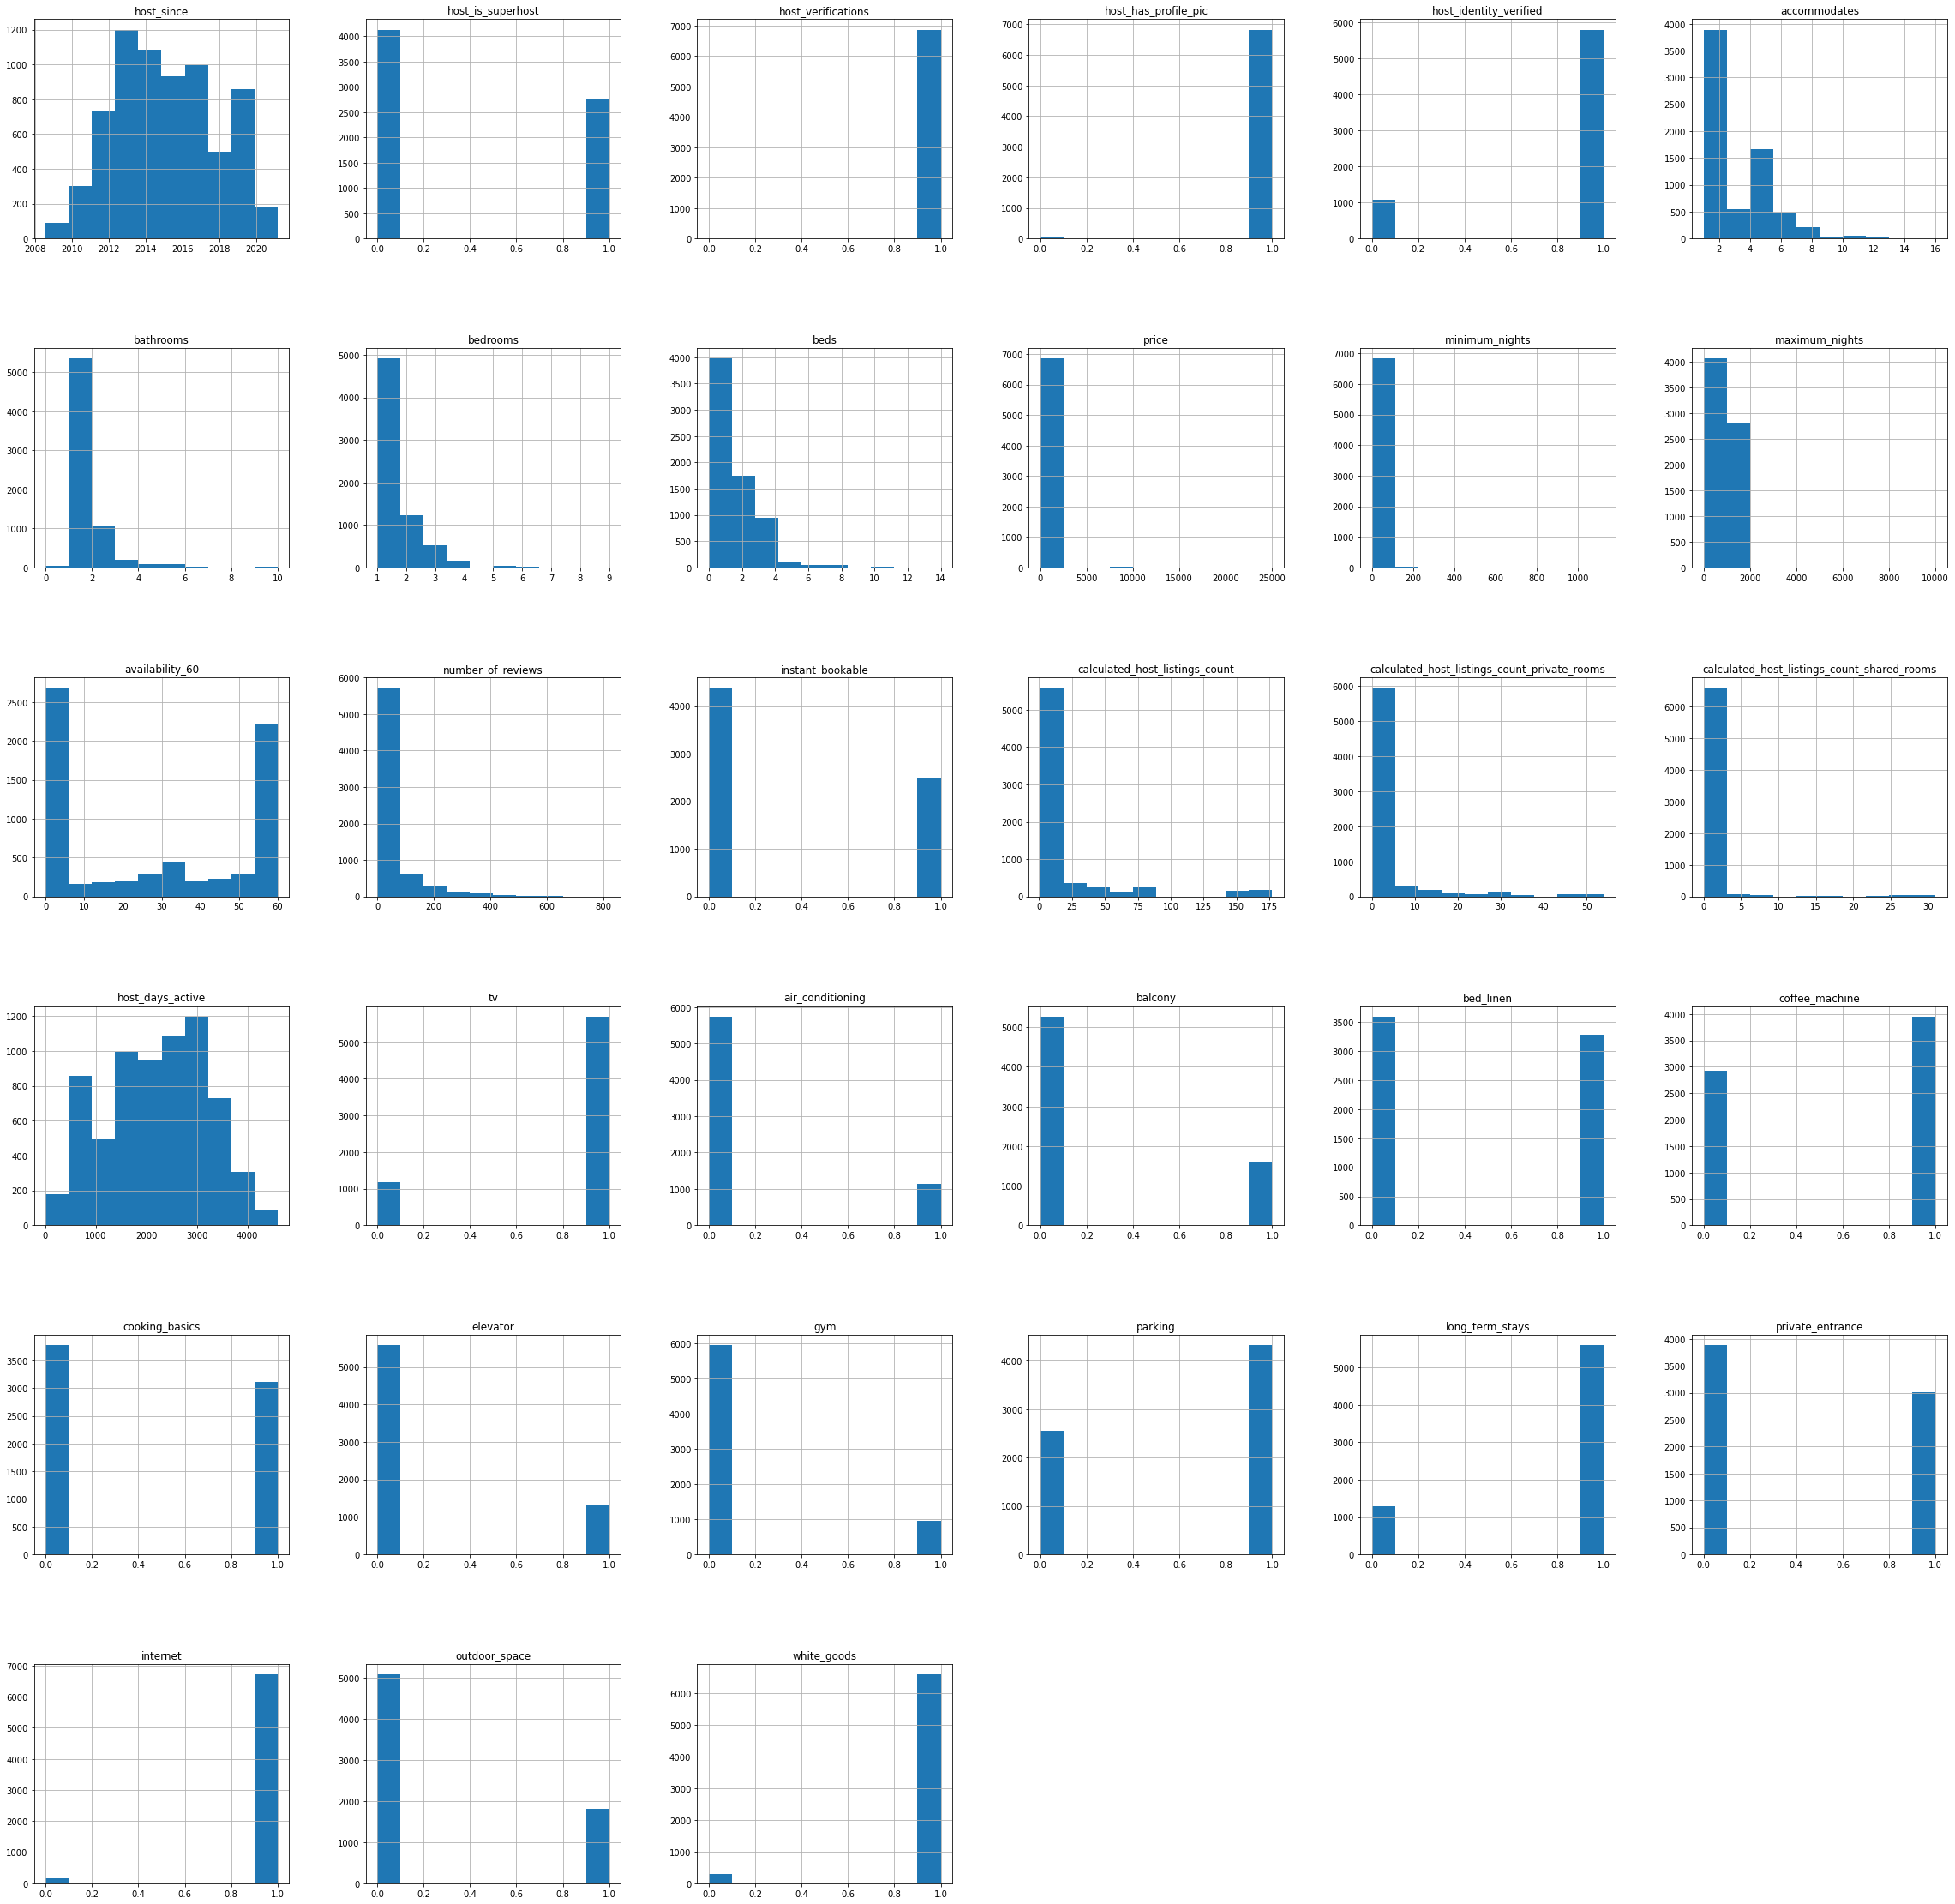

In [6]:
# plotting the distribution of the variables in the listings data frame.

listings.hist(figsize=(40,40))
plt.subplots_adjust(hspace=0.5);

* Histograms reveal that small portion of hosts own large number of listings and majority own single listing. 
* host_listings_count and host_total_listings_count has a very similar distribution, I will check if they have same values or if they are highly correlated. If so I will drop one of the variables.
* Looks like we have a similar situation for the calculted_host_listings_count and calculted_host_listings_count .

In [7]:
# Creating a features dataframe by selecting columns which has data type float64 and int64.

features = listings.select_dtypes(include=['float64','int64'])
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6882 entries, 0 to 6881
Data columns (total 32 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_is_superhost                             6882 non-null   float64
 1   host_verifications                            6882 non-null   int64  
 2   host_has_profile_pic                          6882 non-null   float64
 3   host_identity_verified                        6882 non-null   float64
 4   accommodates                                  6882 non-null   int64  
 5   bathrooms                                     6882 non-null   float64
 6   bedrooms                                      6882 non-null   float64
 7   beds                                          6882 non-null   float64
 8   price                                         6882 non-null   float64
 9   minimum_nights                                6882 non-null   i

In [8]:
listings['beds'].sort_values(ascending=False)

6158    14.0
1444    12.0
3614    12.0
5183    10.0
6074    10.0
        ... 
5904     0.0
4203     0.0
5159     0.0
388      0.0
5225     0.0
Name: beds, Length: 6882, dtype: float64

* I would assume that number of beds, number of bedrooms and number of people a listing can accomodate would have an association with the price column.

In [9]:

# define useful function to create scatterplots of ticket prices against desired columns
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x =col, y = 'price', alpha=0.5,data=features)
        ax.set(xlabel=col, ylabel='price')
    nsubplots = nrow * ncol   
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

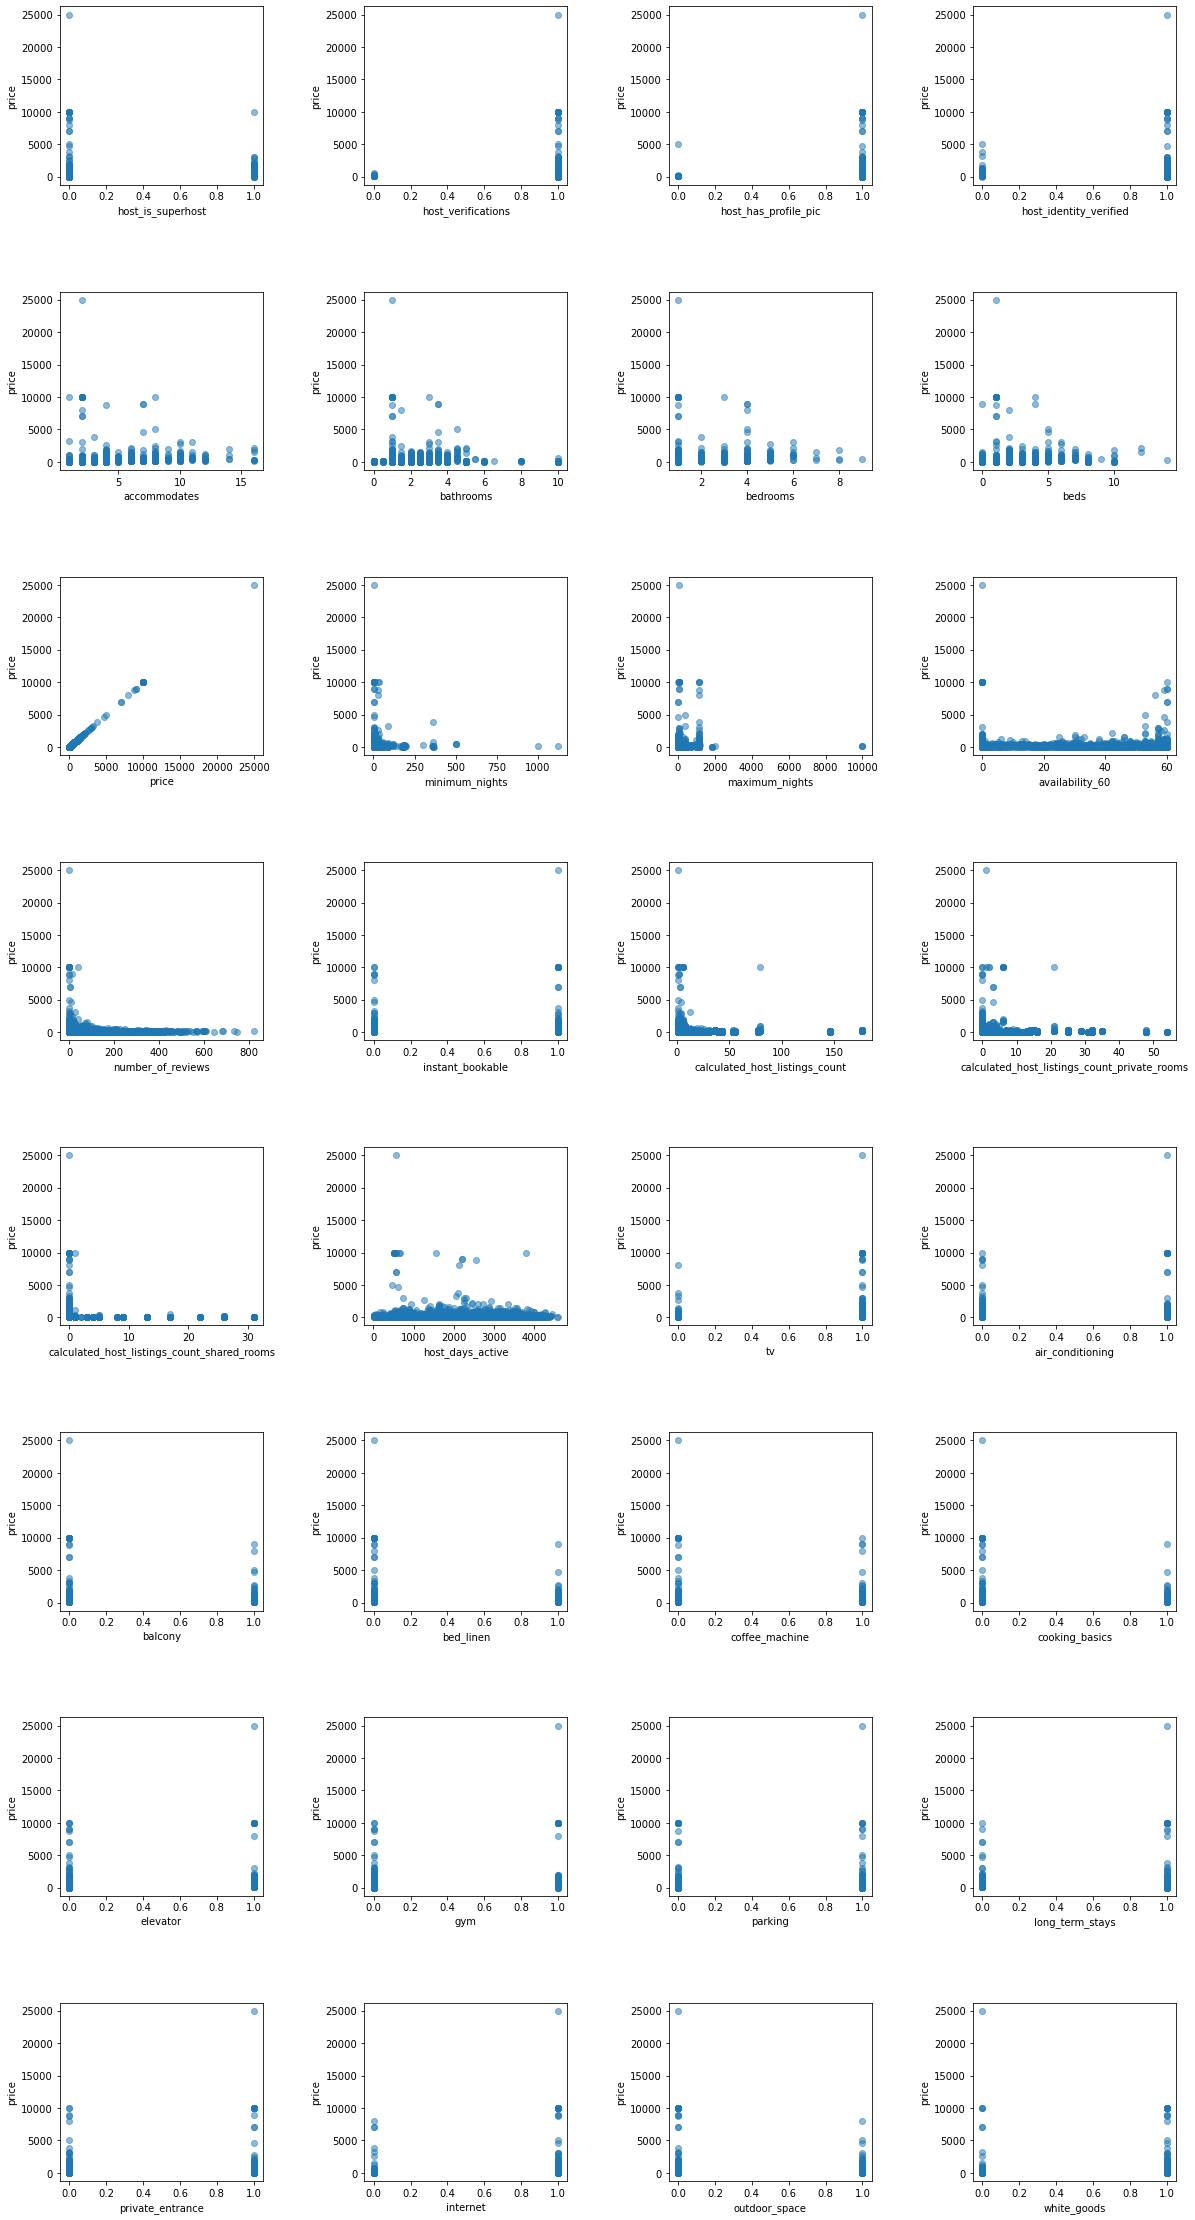

In [10]:
scatterplots(features.columns, ncol=4,figsize=(20,40));

* Since these variables are not continous values and they are mostly discrete it is not possible to see an association using the scatter plot. I will repeat the visualization with the boxplot.

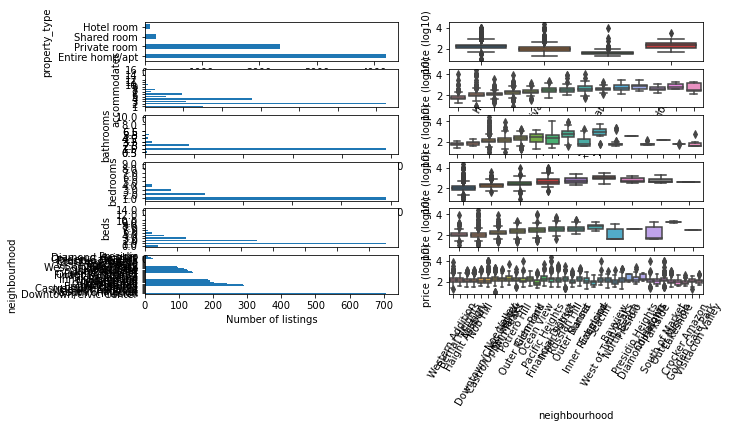

In [11]:
# assigning column names of interest into cols list.
cols = ['property_type','accommodates','bathrooms','bedrooms','beds','neighbourhood']


# plotting barplot to visualize number of subgroups in each column i.e. room_types and price 
# plotting boxplot to visualize subgroups in each column vs the price.

nrow=len(cols)
fig, axs = plt.subplots(nrow,2,figsize=(10,5))
#fig.subplots_adjust(wspace=0.5, hspace=0.6)
for i in range(nrow):
    plt.subplot(nrow,2,2*i+1)
    listings[cols[i]].value_counts().plot(kind='barh')
    plt.ylabel(cols[i])
    plt.xlabel('Number of listings')
    plt.subplot(nrow,2,2*i+2)
    sns.boxplot(x=cols[i], y=np.log10(listings.price), data=listings)
    plt.ylabel('price (log10)')
    plt.xlabel(cols[i])
    plt.xticks(rotation=60)

* Majority of listings are Entire home or apartments. The price distribution of each listing type reveals that hotel rooms tend to be most expensive followed by entire home/apartments. Least expensive listings are shared rooms.

* There is a possitive trend between price of the listings and number of bedrooms, number of beds and number of people a listing can accomodate.

* Price distribution is similar across the neighbourhoods. 

<AxesSubplot:>

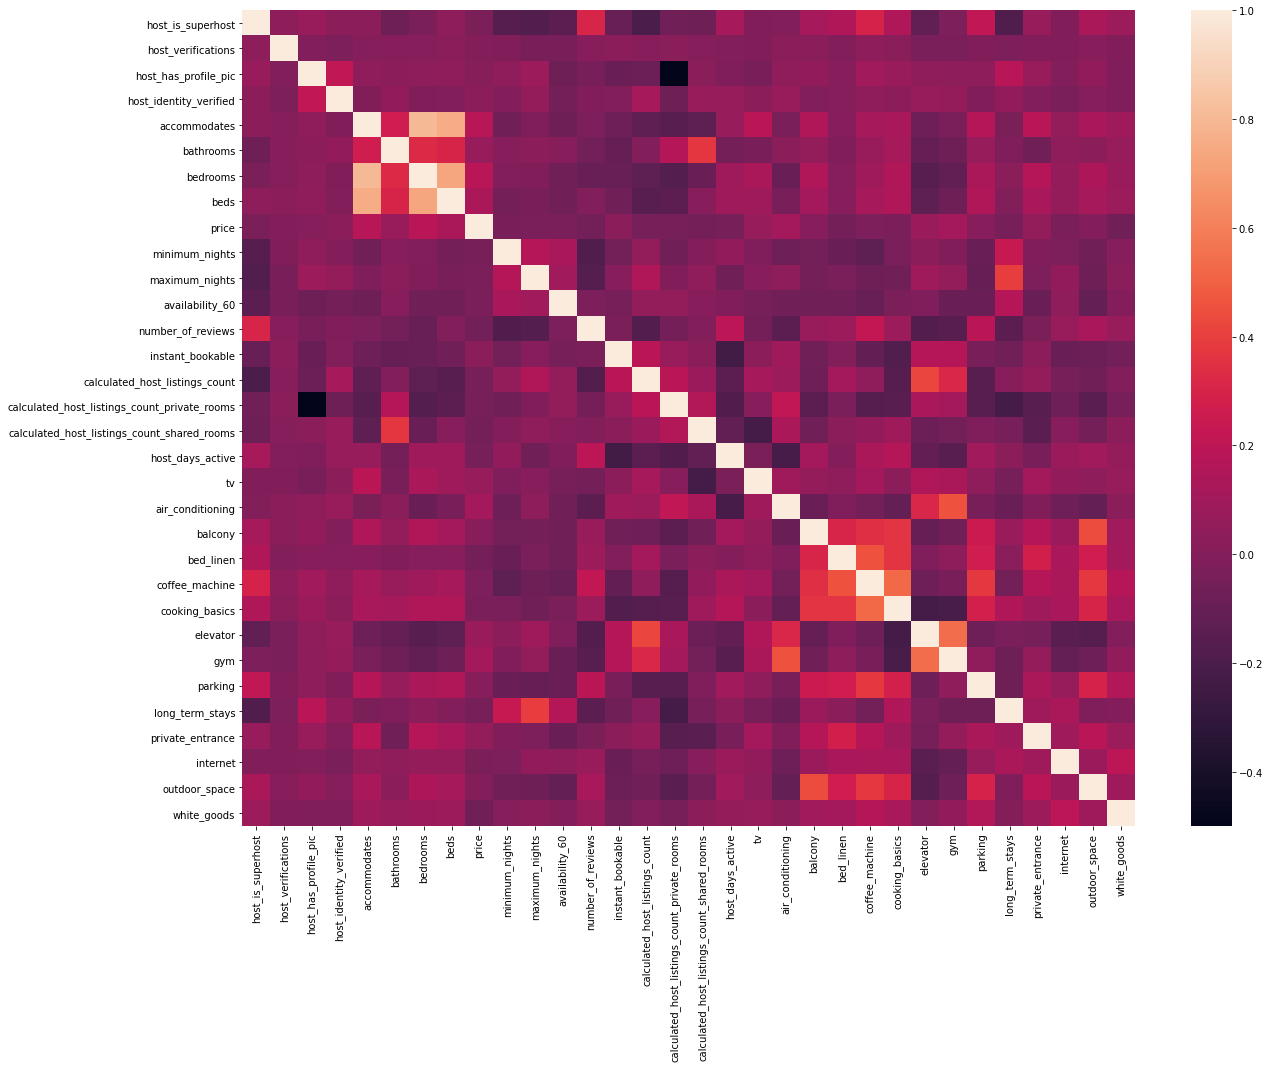

In [12]:
plt.figure(figsize=(20, 15))
sns.heatmap(listings.corr())

* The heatmap reveals that several attributes are highly correlated with each other, i.e. calculated_host_listings_count,total_listings_count. I will need to drop some of these attributes to avoid collinearity.

In [13]:
calendar = pd.read_csv('../data/clean/calendar_clean.csv')

In [14]:
# Changing data type of date column to datetime
calendar['date'] = pd.to_datetime(calendar['date'])

In [15]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,958,2021-03-02,0,130.0,130.0,2,1125
1,53280,2021-03-02,0,95.0,95.0,3,60
2,53280,2021-03-03,0,95.0,95.0,3,60
3,53280,2021-03-04,0,95.0,95.0,3,60
4,53280,2021-03-05,0,95.0,95.0,3,60


In [16]:
calendar['price_difference']=calendar['adjusted_price']-calendar['price']
calendar['weekday'] = pd.Series(calendar.date).dt.dayofweek


In [17]:
df=calendar.groupby('date')[['price']].mean().reset_index()

In [18]:
df2=calendar.groupby('date')[['price']].median().reset_index()

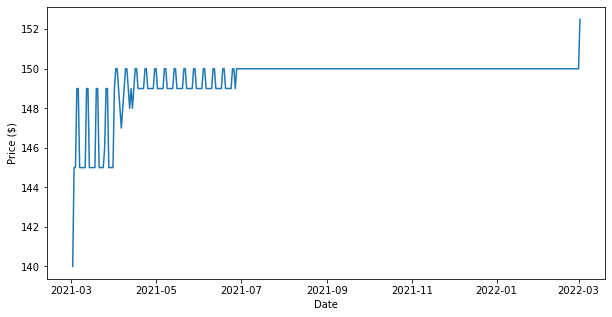

In [19]:
#plt.plot(df.date,df.price)
plt.figure(figsize=(10,5))
plt.plot(df2.date,df2.price)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()